In [1]:
%load_ext autoreload
%autoreload 2

# Counterfactual explanations for the GSMarena dataset

### Installations

Run the following cells to download the repository and install the required packages.

This is needed only on Google Colab, if you are running this notebook locally, you can skip this step.

In [2]:
COLAB_ENV = "google.colab" in str(get_ipython()) if hasattr(__builtins__, "__IPYTHON__") else False
print(f"Currently {'not ' if not COLAB_ENV else ''}running in a Colab environment")

Currently not running in a Colab environment


In [31]:
if COLAB_ENV:
    !mkdir my_repo
    !git clone https://github.com/Valendrew/counterfactual-explanations.git my_repo
    %cd my_repo
    !pip install -r requirements.txt -q

### Import of the libraries

In [2]:
from collections import Counter
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils.util_base_cf import inverse_pipeline

In [3]:
def set_default_randomness(seed: int):
    rng = np.random.RandomState(seed)
    return rng


SEED = 42
rng = set_default_randomness(SEED)

In [4]:
cols_pipeline = pickle.load(open("config/pipeline.pkl", "rb"))

kaggle.json not found, you cannot use kaggle module.


Unique values in the train dataset for discrete features

In [5]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
df_train_post = inverse_pipeline(cols_pipeline, df_train)

discrete_features = df_train_post.columns.drop(["misc_price_min", "misc_price_max", "display_size", "battery"])
print(f"Discrete features: {discrete_features.tolist()}")
for c in discrete_features:
    c_series = df_train_post[c].copy()
    try:
        c_series = c_series.astype(float)
        c_series = c_series.round(2)
    except ValueError:
        c_series = c_series.astype(str)

    print(f"'{c}' unique values: {np.sort(c_series.unique())}")

Discrete features: ['memory_ram_gb', 'memory_rom_gb', 'main_camera_resolution', 'selfie_camera_resolution', 'display_resolution', 'network_technology', 'num_main_camera', 'has_oled_display', 'has_memory_card_slot', 'has_stereo_speakers', 'has_3.5mm_jack', 'has_wlan_5ghz', 'has_nfc', 'has_wireless_charging', 'is_waterproof']
'memory_ram_gb' unique values: [ 1.   1.5  2.   3.   4.   6.   8.  10.  12. ]
'memory_rom_gb' unique values: [  4.   8.  16.  32.  64. 128. 256.]
'main_camera_resolution' unique values: [  3.   4.   5.   7.   9.  11.  12.  13.  14.  16.  18.  19.  20.  22.
  24.  26.  32.  41.  48.  50.  64. 108.]
'selfie_camera_resolution' unique values: [ 1.  3.  4.  5.  6.  7.  9. 11. 12. 13. 16. 20. 24. 26. 32. 41. 44.]
'display_resolution' unique values: ['FHD' 'HD' 'QHD' 'qHD']
'network_technology' unique values: ['3G' '4G' '5G']
'num_main_camera' unique values: [1. 2. 3. 4.]
'has_oled_display' unique values: [0. 1.]
'has_memory_card_slot' unique values: [0. 1.]
'has_stereo_sp

In [173]:
import utils.util_evaluation as util_evaluation

## Evaluation on correctly predicted samples

In [6]:
df_test = pd.read_csv("data/model/gsm_test.csv", index_col=0)

df_test_den = inverse_pipeline(cols_pipeline, df_test)
df_test_den = df_test_den.astype({"num_main_camera": float})

In [101]:
feat_str_dict = {
    "display_resolution": {
        "qHD": 0, "HD": 1, "FHD": 2, "QHD": 3
    },
    "network_technology": {
        "3G": 0, "4G": 1, "5G": 2
    }
}

price_map = {
    40: 0,
    215: 1,
    420: 2
}

In [11]:
feature_columns = df_test_den.columns.drop(["misc_price_min", "misc_price_max"])

In [102]:
df_train = pd.read_csv("data/model/gsm_train.csv", index_col=0)
y_train = df_train.misc_price

df_train = inverse_pipeline(cols_pipeline, df_train)
df_train = df_train[feature_columns]

### OMLT

Read the counterfactual dataset (on the test set) 

In [13]:
df_cf = pd.read_csv("data/counterfactual/multiclass.csv", index_col=0)
df_cf.head()

,misc_price,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
664,1.0,215.0,420.0,6.37,2333.24,4.0,32.0,16.0,13.0,HD,4G,1.0,0,1,0,1,0,0,0,0
1228,1.0,215.0,420.0,6.09,2333.24,2.0,64.0,12.0,13.0,qHD,4G,1.0,1,1,0,1,0,0,0,0
1095,1.0,215.0,420.0,6.37,3436.45,2.0,16.0,12.0,4.0,HD,3G,1.0,1,1,0,1,0,0,0,0
584,1.0,215.0,420.0,4.95,2333.24,2.0,64.0,12.0,12.0,HD,4G,1.0,0,1,0,1,1,1,0,0
120,1.0,215.0,420.0,6.37,4118.63,2.0,16.0,12.0,4.0,HD,4G,2.0,1,1,0,1,0,0,0,1


Read the original test dataset and compute the features in the original space

In [48]:
merge_df = join_merge_columns(df_cf, df_test_den)

,misc_price,misc_price_min_cf,misc_price_max_cf,display_size_cf,battery_cf,memory_ram_gb_cf,memory_rom_gb_cf,main_camera_resolution_cf,selfie_camera_resolution_cf,display_resolution_cf,...,network_technology_original,num_main_camera_original,has_oled_display_original,has_memory_card_slot_original,has_stereo_speakers_original,has_3.5mm_jack_original,has_wlan_5ghz_original,has_nfc_original,has_wireless_charging_original,is_waterproof_original
31,0.0,40.0,215.0,6.20,3092.31,4.0,16.0,16.0,13.0,HD,...,5G,3.0,0,0,0,1,1,0,0,0
31,2.0,420.0,1600.0,6.37,3711.25,4.0,16.0,16.0,13.0,HD,...,5G,3.0,0,0,0,1,1,0,0,0
33,1.0,215.0,420.0,6.37,3854.08,4.0,64.0,16.0,13.0,HD,...,4G,4.0,1,0,0,0,1,1,1,1
40,0.0,40.0,215.0,6.28,4118.60,3.0,64.0,16.0,12.0,HD,...,4G,4.0,0,0,0,1,1,1,0,0
40,2.0,420.0,1600.0,5.62,3616.34,4.0,64.0,17.0,13.0,HD,...,4G,4.0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,2.0,420.0,1600.0,6.37,3425.07,3.0,64.0,17.0,13.0,HD,...,4G,3.0,1,0,0,1,1,1,0,0
1893,1.0,215.0,420.0,6.37,3031.11,4.0,64.0,14.0,8.0,qHD,...,4G,3.0,1,0,0,0,1,1,0,0
1899,1.0,215.0,420.0,6.03,4118.63,4.0,64.0,16.0,14.0,qHD,...,5G,4.0,1,0,0,1,1,1,0,0
1900,0.0,40.0,215.0,5.59,3957.06,4.0,64.0,16.0,13.0,HD,...,4G,4.0,1,1,0,1,1,0,0,0


Count the number of changed features

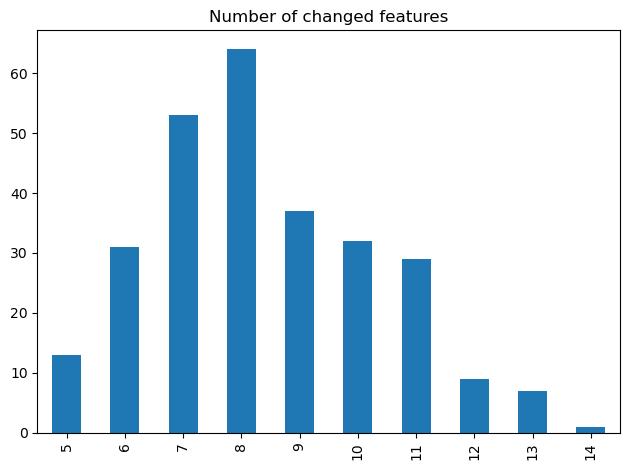

In [49]:
num_changed = merge_df.apply(lambda x: count_changed_features(x, 17), axis=1)
num_changed.value_counts().sort_index().plot.bar(title="Number of changed features")
plt.tight_layout()

In [168]:
num_changed = merge_df.apply(lambda x: count_changed_features(x, 17), axis=1)
least_changed = num_changed[num_changed < 7].index

df_test_raw = pd.read_csv("data/processed/gsm_test.csv", index_col=0)
price_least_changed =df_test_raw.loc[least_changed]["misc_price"]
price_least_changed[(210 <= price_least_changed) & (price_least_changed <= 420)].mean()

291.80947368421056

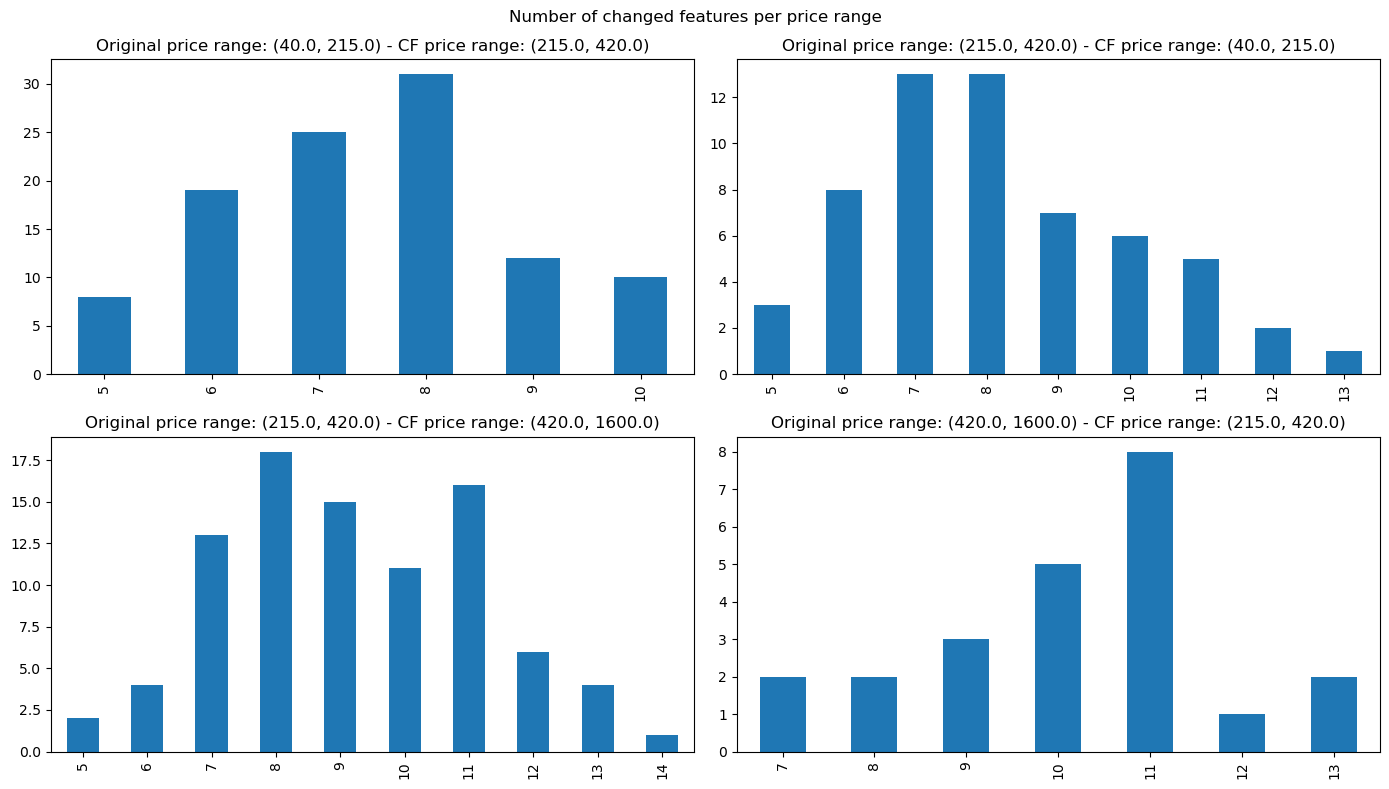

In [50]:
plot_changed_features_count(merge_df)

The type of features that have been changed the most

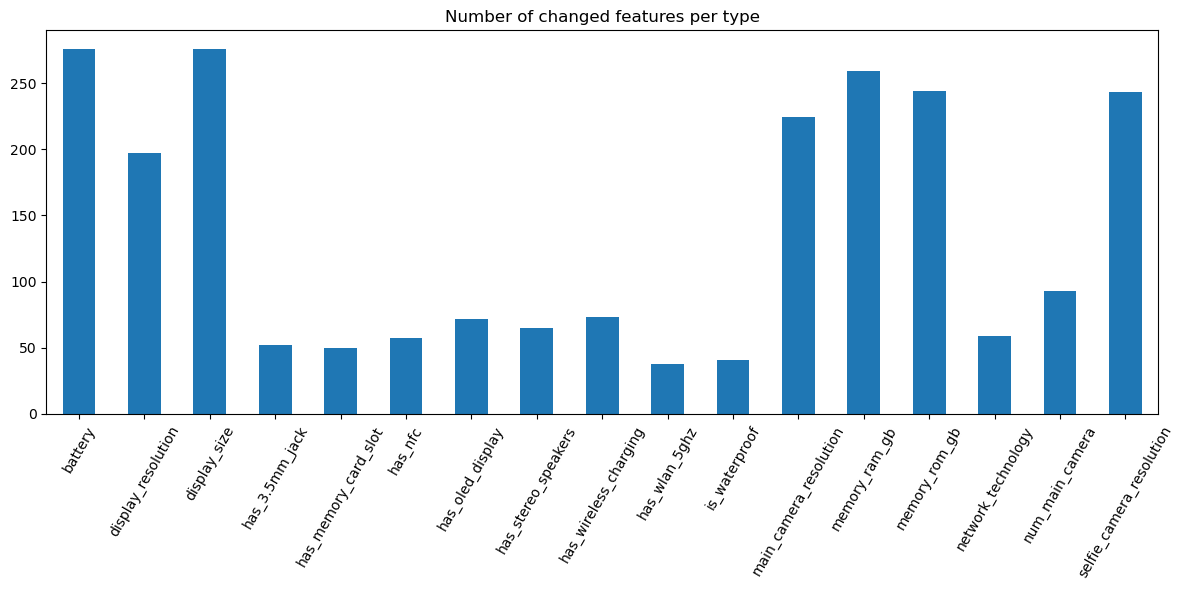

In [141]:
feature_columns = df_test_post.columns.drop(["misc_price_min", "misc_price_max"])
features_changed = Counter(np.concatenate(merge_df.apply(count_type_features, columns=feature_columns, axis=1).values))
features_changed = pd.Series(features_changed).sort_index()
features_changed.plot.bar(title="Number of changed features per type", rot=60, figsize=(12, 6))
plt.tight_layout()

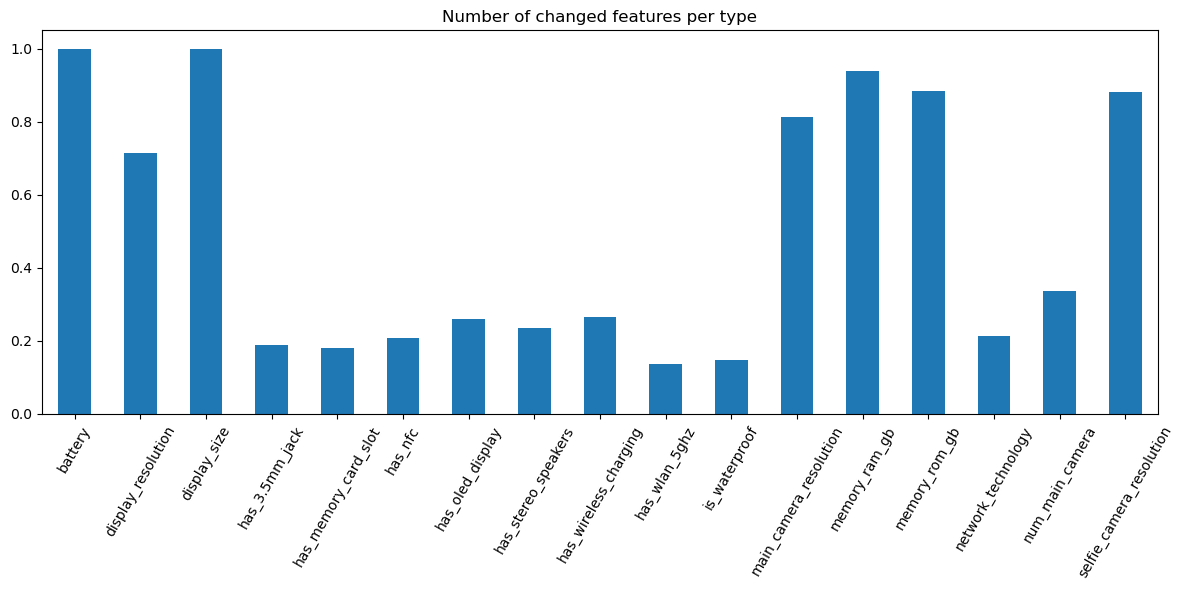

In [51]:
feature_columns = df_test_den.columns.drop(["misc_price_min", "misc_price_max"])
features_changed = Counter(np.concatenate(merge_df.apply(count_type_features, columns=feature_columns, axis=1).values))
features_changed = pd.Series(features_changed).sort_index() / len(merge_df)
features_changed.plot.bar(title="Number of changed features per type", rot=60, figsize=(12, 6))
plt.tight_layout()

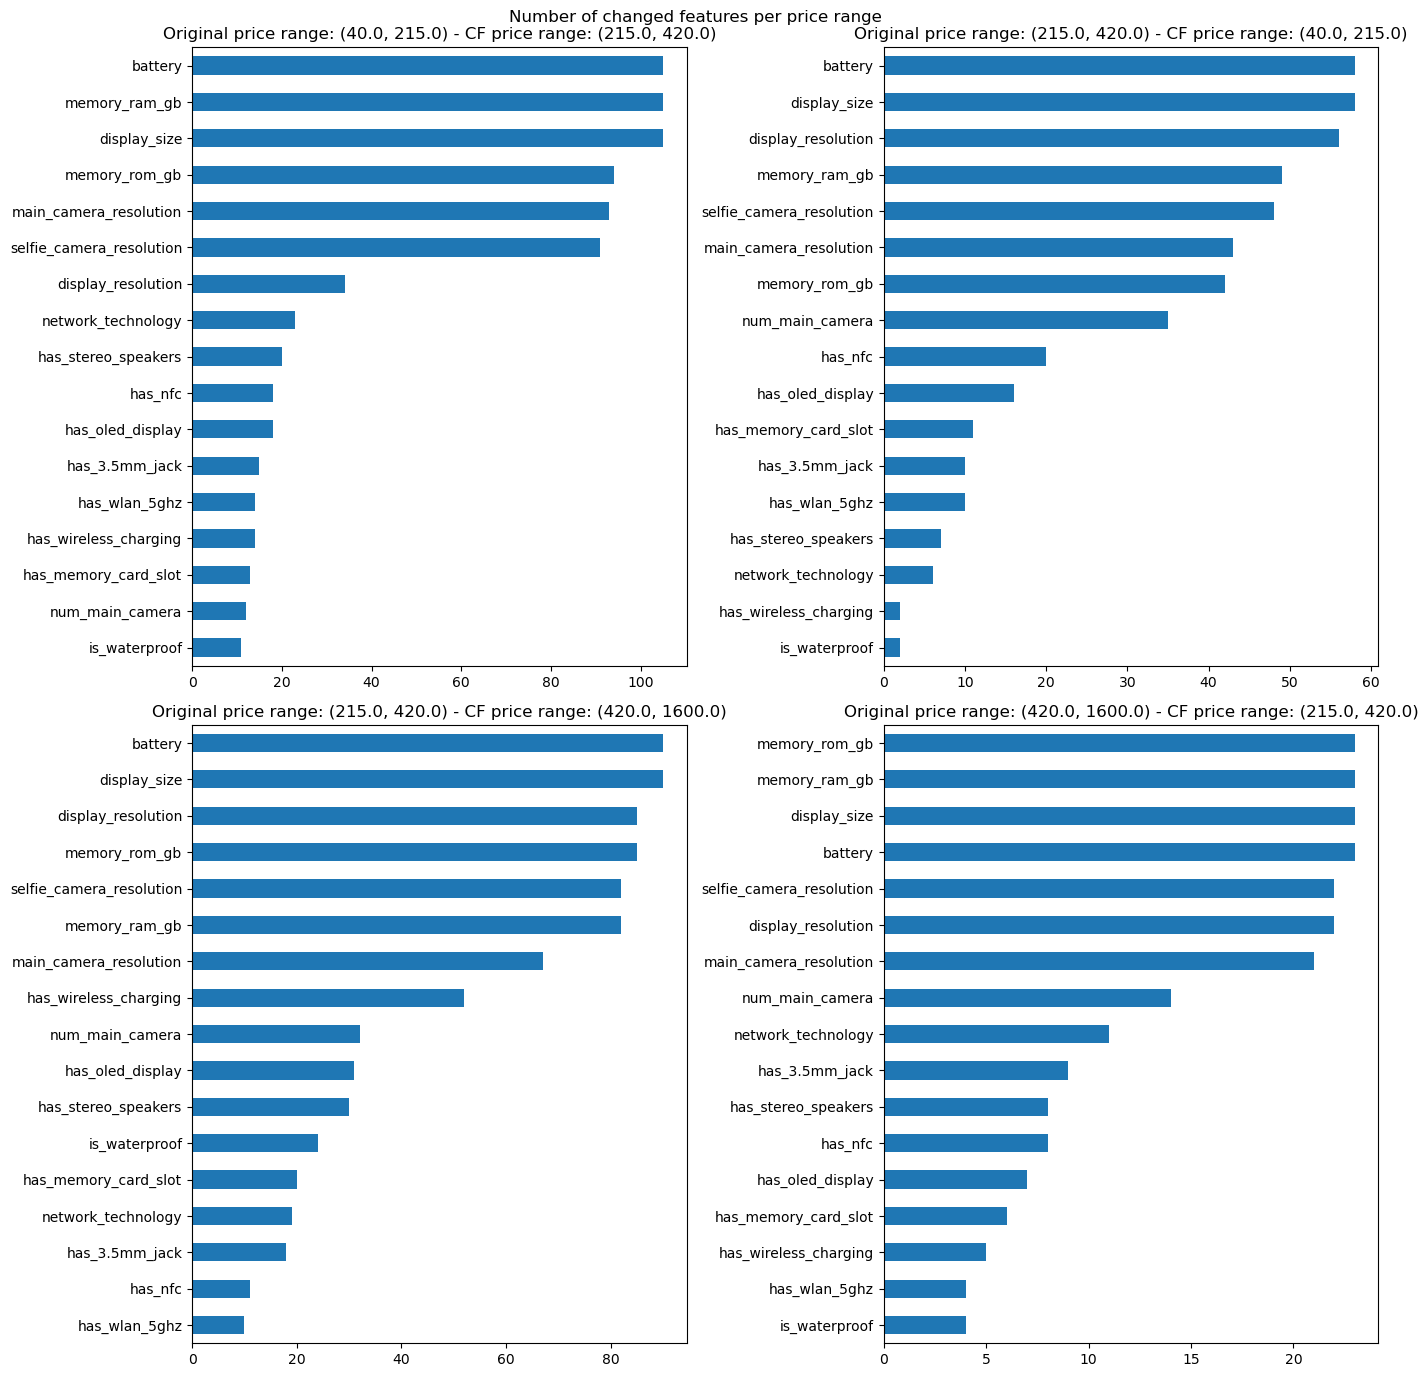

In [148]:
plot_changed_features(merge_df, feat_columns)

In [60]:
show_sample(merge_df, 919)

,919
battery_cf,3072.040000
battery_original,4100.000000
display_resolution_cf,HD
display_resolution_original,FHD
display_size_cf,5.920000
display_size_original,5.500000
has_3.5mm_jack_cf,0.000000
has_3.5mm_jack_original,1
has_memory_card_slot_cf,1.000000
has_memory_card_slot_original,0


### Dice

In [134]:
df_dice_corr = pd.read_csv("data/counterfactual/corr_cf_dice.csv", index_col=0)

# Cast types
df_dice_corr = util_evaluation.cast_round_type(df_dice_corr, df_test_den.dtypes.to_dict())
print(f"The dataframe has {df_dice_corr.shape[0]} rows.")

The dataframe has 372 rows.


In [15]:
dice_merge = util_evaluation.join_merge_columns(df_dice_corr, df_test_den)

,misc_price_min_cf,misc_price_max_cf,display_size_cf,battery_cf,memory_ram_gb_cf,memory_rom_gb_cf,main_camera_resolution_cf,selfie_camera_resolution_cf,display_resolution_cf,network_technology_cf,...,network_technology_original,num_main_camera_original,has_oled_display_original,has_memory_card_slot_original,has_stereo_speakers_original,has_3.5mm_jack_original,has_wlan_5ghz_original,has_nfc_original,has_wireless_charging_original,is_waterproof_original
16,215.0,420.0,6.01,5000.0,4.0,64.0,17.0,16.0,FHD,4G,...,4G,2.0,0,1,0,1,0,0,0,0
31,40.0,215.0,6.59,4000.0,4.0,64.0,49.0,16.0,FHD,4G,...,5G,3.0,0,0,0,1,1,0,0,0
31,420.0,1600.0,6.44,4400.0,6.0,128.0,49.0,16.0,QHD,5G,...,5G,3.0,0,0,0,1,1,0,0,0
33,215.0,420.0,6.26,4000.0,8.0,128.0,49.0,33.0,FHD,4G,...,4G,4.0,1,0,0,0,1,1,1,1
40,40.0,215.0,6.30,4035.0,4.0,64.0,49.0,16.0,FHD,4G,...,4G,4.0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1890,420.0,1600.0,6.70,4000.0,8.0,256.0,49.0,33.0,QHD,4G,...,4G,3.0,1,0,0,1,1,1,0,0
1893,215.0,420.0,6.38,4500.0,6.0,128.0,17.0,33.0,FHD,4G,...,4G,3.0,1,0,0,0,1,1,0,0
1899,215.0,420.0,6.50,4500.0,6.0,128.0,49.0,33.0,QHD,5G,...,5G,4.0,1,0,0,1,1,1,0,0
1900,40.0,215.0,6.50,4300.0,4.0,64.0,49.0,16.0,QHD,4G,...,4G,4.0,1,1,0,1,1,0,0,0


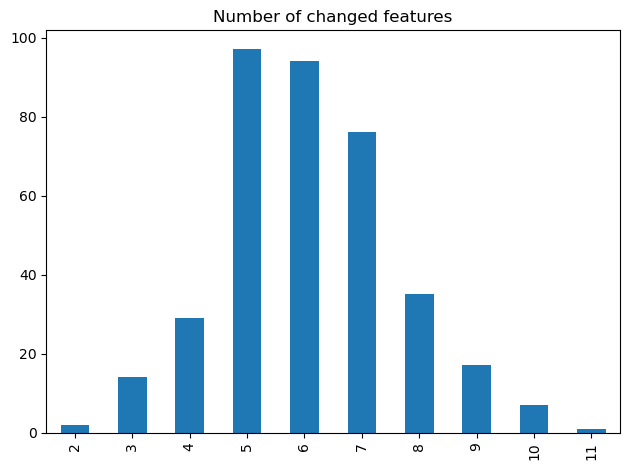

In [16]:
num_changed = dice_merge.apply(lambda x: util_evaluation.count_changed_features(x, 17), axis=1)
num_changed.value_counts().sort_index().plot.bar(title="Number of changed features")
plt.tight_layout()

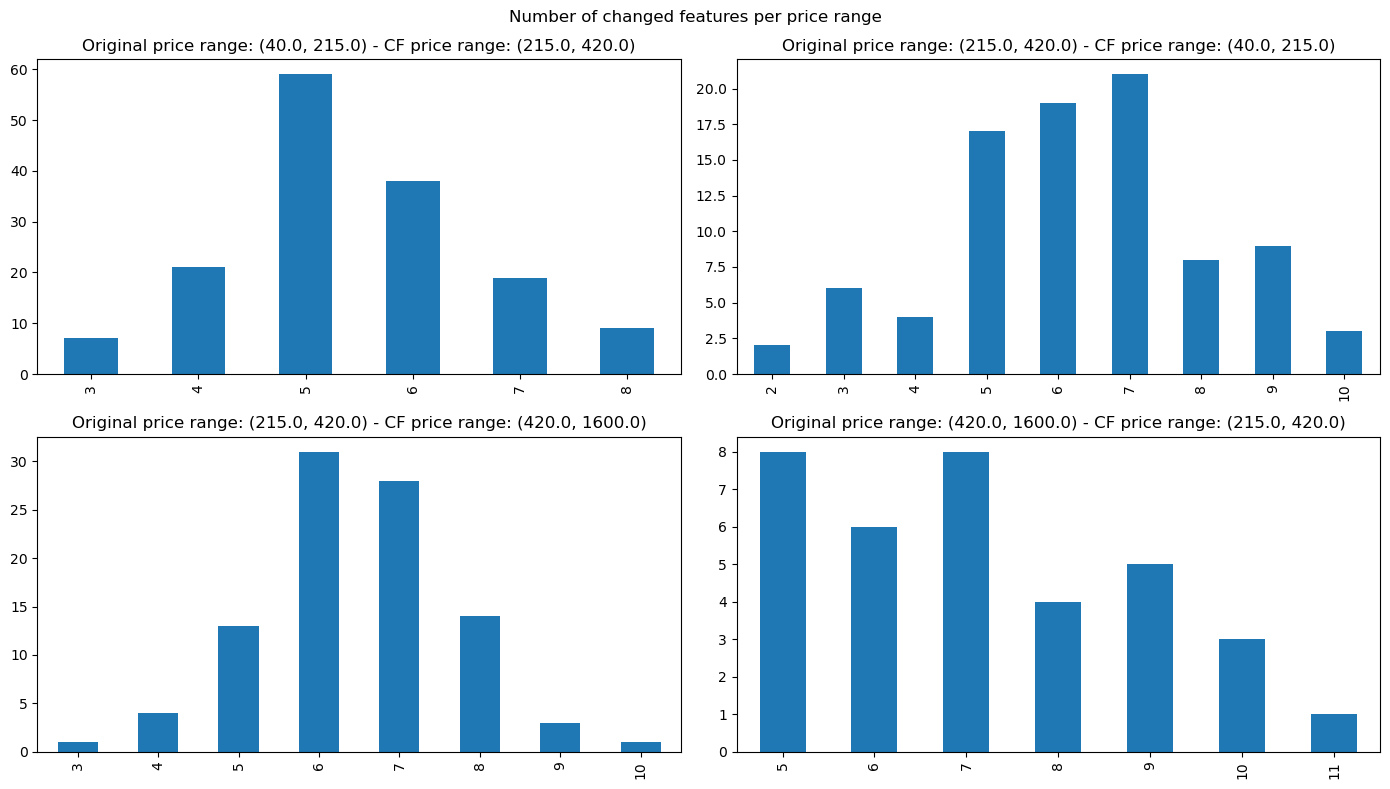

In [37]:
util_evaluation.plot_changed_features_count(dice_merge)

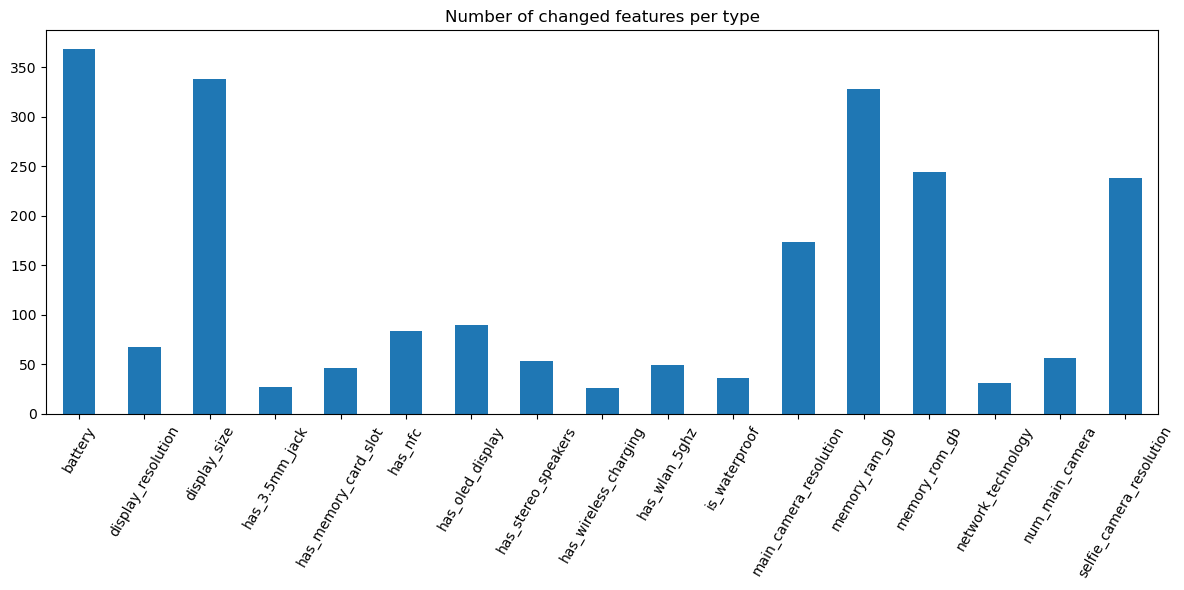

In [17]:
features_changed = Counter(np.concatenate(dice_merge.apply(util_evaluation.count_type_features, columns=feature_columns, axis=1).values))
features_changed = pd.Series(features_changed).sort_index()
features_changed.plot.bar(title="Number of changed features per type", rot=60, figsize=(12, 6))
plt.tight_layout()

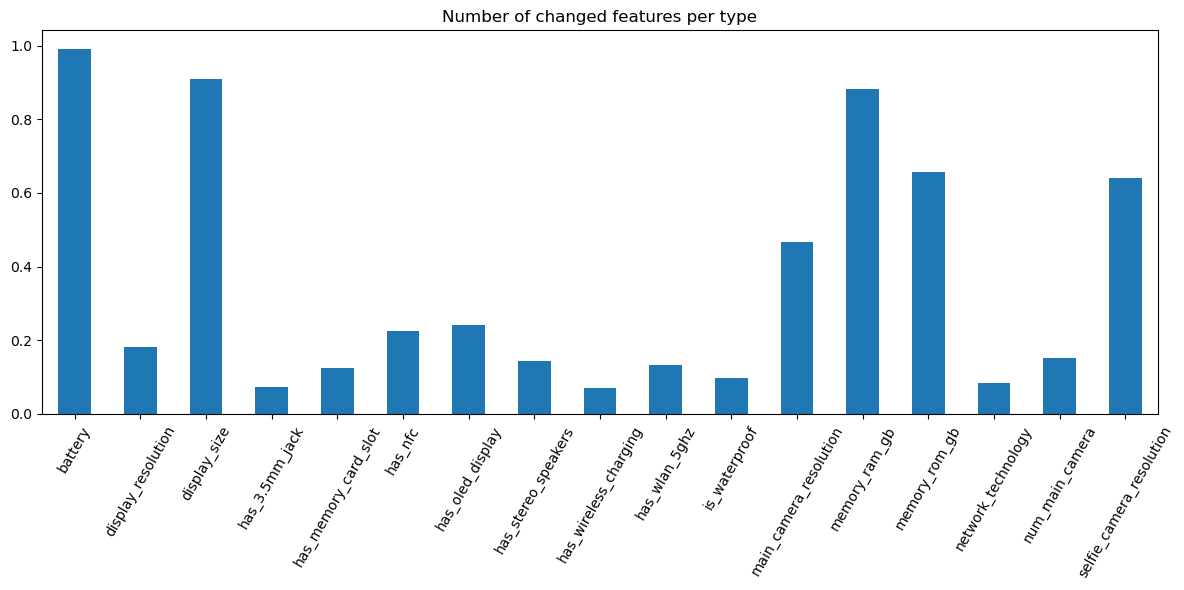

In [18]:
features_changed = Counter(np.concatenate(dice_merge.apply(util_evaluation.count_type_features, columns=feature_columns, axis=1).values))
features_changed = pd.Series(features_changed).sort_index() / dice_merge.shape[0]
features_changed.plot.bar(title="Number of changed features per type", rot=60, figsize=(12, 6))
plt.tight_layout()

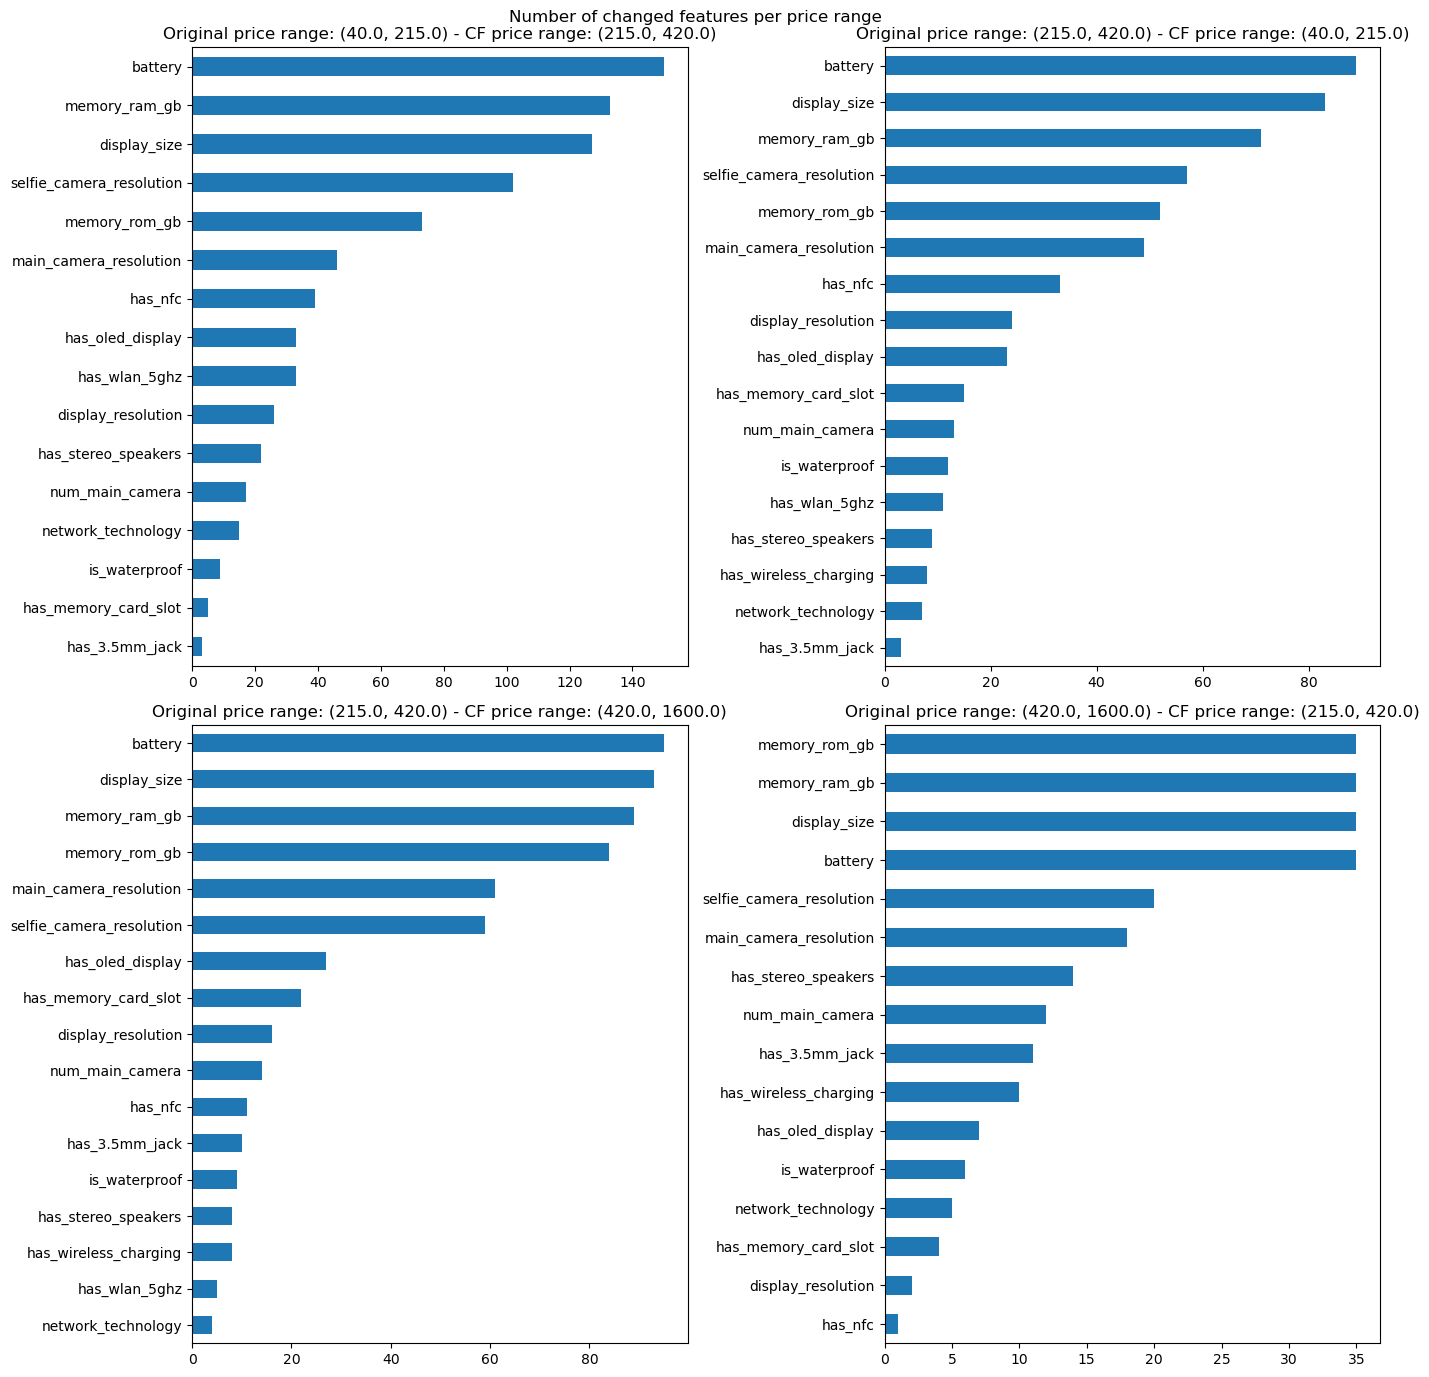

In [54]:
util_evaluation.plot_changed_features(dice_merge, feature_columns)

#### Compute closest devices to the generated counterfactuals

In [104]:
df_train = util_evaluation.convert_string_feat(df_train, feat_str_dict)
df_dice_corr = util_evaluation.convert_string_feat(df_dice_corr, feat_str_dict)

y_dice = df_dice_corr.misc_price_min.astype(int).replace(price_map)

df_tsne = pd.concat([df_train, df_dice_corr[feature_columns]], axis=0)
y_tsne = pd.concat([y_train, y_dice])

assert df_tsne.shape[0] == len(y_tsne)

In [133]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler())
pipe.set_output(transform="pandas")

df_tsne = pipe.fit_transform(df_tsne)

In [132]:
idx = 314

In [122]:
from sklearn.pipeline import make_pipeline

pipe_tmp = make_pipeline(StandardScaler())
pipe_tmp.set_output(transform="pandas")

tmp_df = pipe_tmp.fit_transform(df_train)
tmp_sample = pipe_tmp.transform(df_dice_corr.loc[[idx], feature_columns])

In [124]:
s = tmp_df[y_train == 0]

d = s.apply(lambda x: util_evaluation.compute_distance(x, tmp_sample.iloc[0]), axis=1)
d = d.sort_values()

min_index = d.index[0]
closer_sample = df_train.loc[min_index]

assert min_index not in df_dice_corr.index, "The index is present in the dataframe of counterfactuals"

# closer_sample
print(f"Distance to the closest sample: {d.loc[min_index]}\n")
print(f"Price of the closest sample: {y_train.loc[min_index]}\n")
print(f"Features of the closest sample:\n")
closer_sample.to_frame().T

Distance to the closest sample: 0.0714512804478111

Price of the closest sample: 0

Features of the closest sample:



,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
357,6.36,4000.0,3.0,32.0,16.0,13.0,2,1,2.0,0,1,0,1,1,0,0,0


In [131]:
df_dice_corr.loc[idx].iloc[0].to_frame().T

,misc_price_min,misc_price_max,display_size,battery,memory_ram_gb,memory_rom_gb,main_camera_resolution,selfie_camera_resolution,display_resolution,network_technology,num_main_camera,has_oled_display,has_memory_card_slot,has_stereo_speakers,has_3.5mm_jack,has_wlan_5ghz,has_nfc,has_wireless_charging,is_waterproof
314,40.0,215.0,6.36,4000.0,3.0,32.0,17.0,13.0,2.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0


In [149]:
# Find the changed features and put 0 and 1
def find_changed_feat(data, df_test):
    orig = df_test.loc[data.name]
    
    return orig == data


res = df_dice_corr.apply(find_changed_feat, df_test=df_test_den, axis=1).astype(int)
res = res.drop(["misc_price_min", "misc_price_max"], axis=1)

res.to_csv("changed_features_dice.csv")

314
1861
1339
664
918
696
184
1549
1228
1098
1429
330
1076
645
1095
1031
1832
1109
1629
584
713
102
569
1010
114
120
1890
1337
1068
656
744
1310
914
1266
1534
897
125
69
1780
88
986
339
446
1360
1038
1205
1150
1516
141
535
218
1545
583
1002
1162
1741
214
1117
1585
777
1571
1668
489
1691
1735
1016
359
636
1383
1648
1006
778
418
754
1140
1120
978
1812
68
850
1509
289
1716
240
1104
932
618
304
801
210
785
1367
922
161
973
686
861
211
570
1042
1718
268
1079
329
1802
1572
1660
1040
119
615
1870
987
1425
800
1686
588
74
1023
1428
338
1394
309
501
87
1458
1341
767
1751
1745
542
862
1482
1771
855
1664
1053
746
1326
659
287
1773
545
1850
1406
462
1840
497
1654
1250
1865
944
1378
647
1066
1641
1073
1009
1215
1292
1245
194
508
1017
450
949
1253
1851
628
843
1889
1220
1743
1700
1452
333
1761
1580
271
400
1769
341
1237
1271
704
1151
762
1445
1035
1723
1265
133
485
105
1711
388
708
1845
116
1344
821
473
429
31
1899
33
1145
595
40
1335
1183
828
1072
1127
1562
1866
979
1290
839
1900
1258
1806
1291
174

In [166]:
import pgmpy as pg
from pgmpy.estimators import HillClimbSearch, BicScore, MmhcEstimator

In [154]:
from itertools import combinations

import networkx as nx
from sklearn.metrics import f1_score

In [168]:
est = HillClimbSearch(res)

bay_model = est.estimate(scoring_method=BicScore(res))

c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for z_state, df in data.groupby(Z):
c:\Users\danie\miniconda3\envs\master-aiii\lib\site-packages\pgmpy\estimators\CITests.py:548: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid

KeyboardInterrupt: 

Text(0.5, 1.0, 'My Bayesian network')

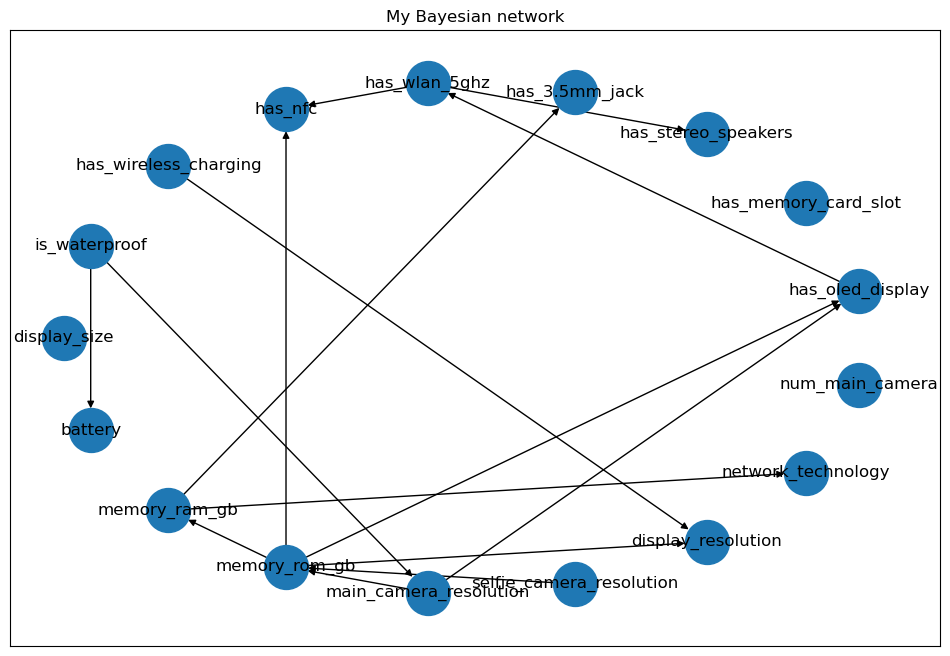

In [165]:
# Draw the network
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
nx.draw_networkx(bay_model, pos=nx.drawing.layout.shell_layout(bay_model), ax=ax, node_size=1000)
ax.set_title('My Bayesian network')